In [1]:
from data import create_dataset, make_DataLoader, data_visualization

from model import Scene_Graph_Model

from utils import train_model, test_model, count_parameters, plot_loss, print_relationships

import torch as th

/orfeo/cephfs/home/dssc/stumino/deep_learning/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


# Data Generation

`NUM_IMAGES` images of simple geometric shapes (rectangles, circles and triangles) are going to be generated using matplotlib.

A random number of shapes (maximum in `MAX_OBJECTS`) will be placed on a `IMAGE_SIZE`x`IMAGE_SIZE` image with a white background, with random colors and positions.

The images and the corresponding annotations (class labels and bounding boxes) will be th.saved.

## Image generation

In [2]:
#Constants
TRAIN_IMAGE_DIR = 'train_images'
TEST_IMAGE_DIR = 'test_images'
DATA_DIR = 'data'
TRAIN_ANNOTATIONS = 'train_data.tensor'
TEST_ANNOTATIONS = 'test_data.tensor'
IMAGE_SIZE = 128
SHAPE_SIZE_MIN = 10
SHAPE_SIZE_MAX = 35
NUM_TRAIN_IMAGES = 10000
NUM_TEST_IMAGES = 2000
MAX_OBJECTS = 4

In [10]:
# Generate images
train_data, train_relationships = create_dataset(NUM_TRAIN_IMAGES, IMAGE_SIZE, TRAIN_IMAGE_DIR, MAX_OBJECTS, SHAPE_SIZE_MIN, SHAPE_SIZE_MAX, geometric=False, rotate=False, origami=True)

# save annotations
th.save(train_data, DATA_DIR + '/' + TRAIN_ANNOTATIONS)
th.save(train_relationships, DATA_DIR + '/train_relationships.tensor')

The directory train_images already exists. Do you want to delete it? [y/n]


 y


Creating image dataset, size: 22.32 MB: 100%|████████████████████████████████████| 10000/10000 [07:23<00:00, 22.53it/s]


In [11]:
# Generate images
test_data, test_relationships = create_dataset(NUM_TEST_IMAGES, IMAGE_SIZE, TEST_IMAGE_DIR, MAX_OBJECTS, SHAPE_SIZE_MIN, SHAPE_SIZE_MAX, geometric=False, rotate=False, origami=True)

# save annotations
th.save(test_data, DATA_DIR + '/' + TEST_ANNOTATIONS)
th.save(test_relationships, DATA_DIR + "/test_relationships.tensor")

The directory test_images already exists. Do you want to delete it? [y/n]


 y


Creating image dataset, size: 4.47 MB: 100%|███████████████████████████████████████| 2000/2000 [01:26<00:00, 23.15it/s]


## Display Data

### Data Visualization

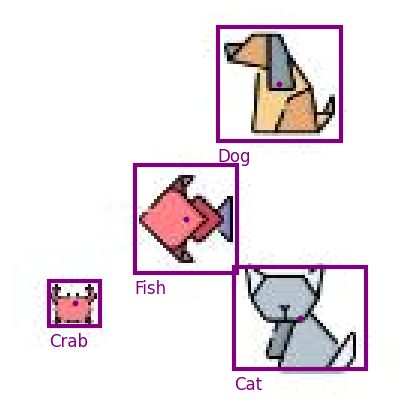

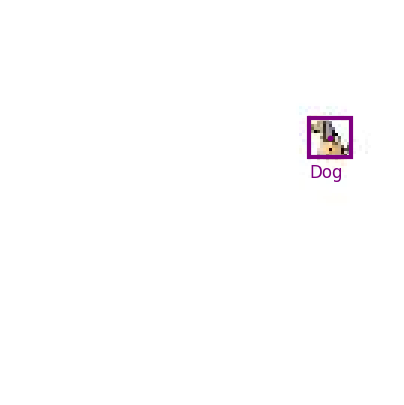

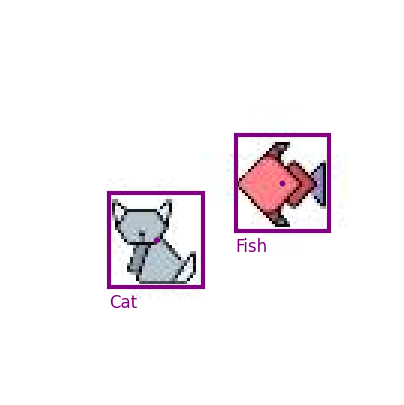

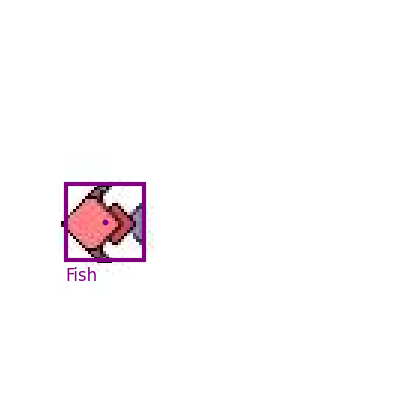

In [12]:
data_visualization(real=True, origami=True)

## DataLoader

### Image loading

In [13]:
make_DataLoader(TRAIN_IMAGE_DIR, TEST_IMAGE_DIR, IMAGE_SIZE, DATA_DIR, TRAIN_ANNOTATIONS, TEST_ANNOTATIONS)

Loading the images in test_images...: 100%|██████████████████████████████████████| 2000/2000 [00:00<00:00, 2724.22it/s]


# Model

In [12]:
train_loader = th.load('./dataloaders/train_loader.tensor')
test_loader = th.load('./dataloaders/test_loader.tensor')

In [9]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

# model = Scene_Graph_Model(num_boxes=5, num_classes=3, num_relation=6).to(device)
model = Scene_Graph_Model(num_boxes=4, num_classes=4, num_relation=6).to(device)

# criterion = lambda y_hat, y, relation_out, relation: th.nn.functional.cross_entropy(y_hat[:, 0, :4], y[:, 0, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 1, :4], y[:, 1, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 2, :4], y[:, 2, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 3, :4], y[:, 3, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 4, :4], y[:, 4, :4]) \
#                             + th.nn.functional.mse_loss(y_hat[:, :, 4:], y[:, :, 4:]) \
#                             + th.nn.functional.binary_cross_entropy_with_logits(relation_out, relation)

criterion = lambda y_hat, y, relation_out, relation: th.nn.functional.cross_entropy(y_hat[:, 0, :5], y[:, 0, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 1, :5], y[:, 1, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 2, :5], y[:, 2, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 3, :5], y[:, 3, :5]) \
                                                   + th.nn.functional.mse_loss(y_hat[:, :, 5:], y[:, :, 5:]) \
                                                   + th.nn.functional.binary_cross_entropy_with_logits(relation_out, relation)

In [13]:
optimizer = th.optim.Adam(model.parameters(), lr=1e-4)
model, train_loss, test_loss = train_model(model, optimizer, criterion, train_loader, test_loader, 5)

Loss 14.4926/17.7276, Acc 0.92/0.92, Relation: 0.91/0.91: 100%|██████████████████████████| 5/5 [00:22<00:00,  4.48s/it]


In [6]:
count_parameters(model)

+-------------------------------+------------+
|            Modules            | Parameters |
+-------------------------------+------------+
|       block1.0.0.weight       |    432     |
|        block1.0.0.bias        |     16     |
|       block1.0.1.weight       |     16     |
|        block1.0.1.bias        |     16     |
|       block1.1.0.weight       |    4608    |
|        block1.1.0.bias        |     32     |
|       block1.1.1.weight       |     32     |
|        block1.1.1.bias        |     32     |
|       block1.2.0.weight       |   18432    |
|        block1.2.0.bias        |     64     |
|       block1.2.1.weight       |     64     |
|        block1.2.1.bias        |     64     |
|       block1.3.0.weight       |   73728    |
|        block1.3.0.bias        |    128     |
|       block1.3.1.weight       |    128     |
|        block1.3.1.bias        |    128     |
|       block1.4.0.weight       |   32768    |
|        block1.4.0.bias        |    256     |
|       block

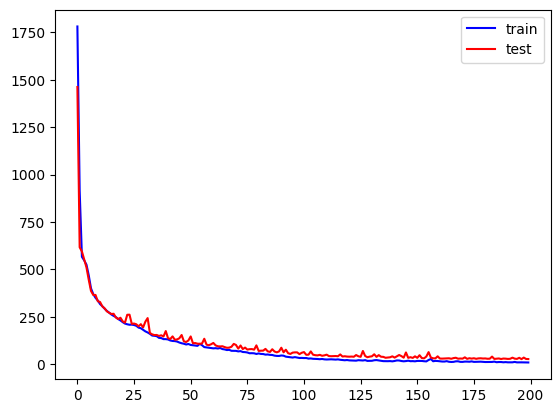

In [7]:
plot_loss(train_loss, test_loss)

In [14]:
# save the model
# os.makedirs('./models', exist_ok=True)
# th.save(model.state_dict(), './models/best_origami_model.pth')

In [10]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = Scene_Graph_Model(num_boxes=4, num_classes=4, num_relation=6).to(device)
# weights = th.load('./models/best_geometric_model.pth')
weights = th.load('./models/best_origami_model.pth')
# weights = th.load('./models/best_realimage_model.pth')
model.load_state_dict(weights)

<All keys matched successfully>

Creating image dataset, size: 0.00 MB: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


TypeError: __call__() got an unexpected keyword argument 'keys'

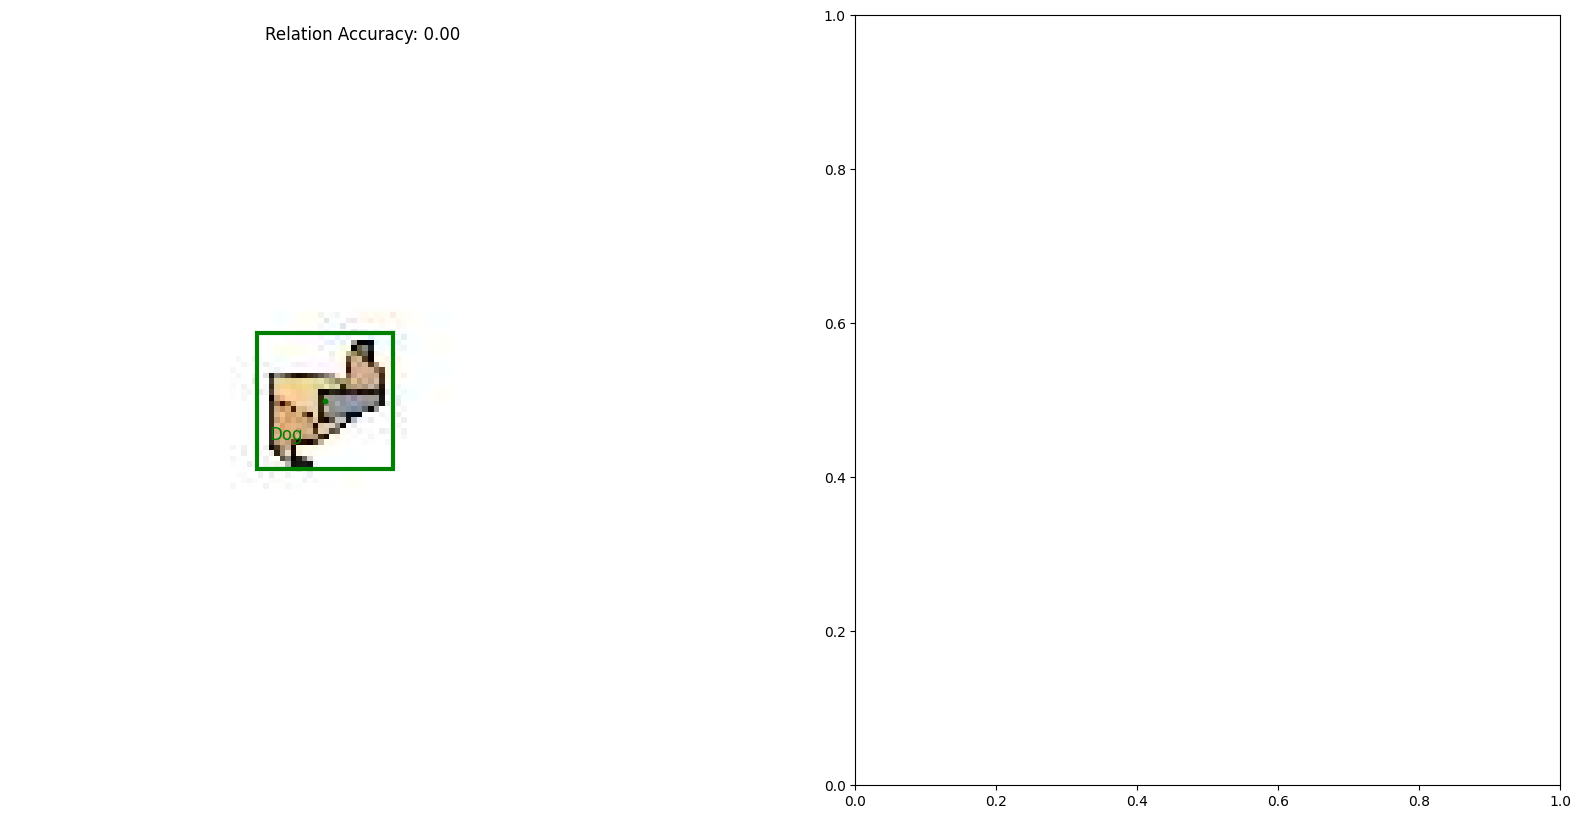

In [7]:
test_image_data, relation, out, out_relation = test_model(model, device, DATA_DIR, geometric=False, rotate=True, origami=True)

In [ ]:
print_relationships((th.sigmoid(out_relation[0]) > 0.5).int(), out)

In [ ]:
print_relationships(relation[0], out)